In [1]:
!pip install geemap

In [2]:
import hydrofunctions as hf
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import folium
import geemap.foliumap as geemap
import ee
import matplotlib.dates as mdates
import hydrofns
import calendar
import pandas as pd

%matplotlib inline

In [3]:
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AX4XfWjS5sfYrYhyyPVF4JLs9wZG45mKdanxWCAiWwv6IBqHTgPOaSC3Rmk

Successfully saved authorization token.


In [7]:
# site number for NWIS gage (Vicksburg MS Site)
vicksburg = ['07289000']

# Coordinates for the bounds of a rectangle at Vicksburg MS
vicksburg_xMin = -91.2
vicksburg_yMin = 32
vicksburg_xMax = -90.8
vicksburg_yMax = 32.7

# Vicksburg geometry
vicksburg_rectangleGeoJSON = ee.Geometry.Rectangle(
    [
        [vicksburg_xMin, vicksburg_yMin],
        [vicksburg_xMax, vicksburg_yMax]   # max x and y
    ]
)


vicksburg_bnds = ee.FeatureCollection([
    ee.Feature(
        vicksburg_rectangleGeoJSON,
        {'name': 'Mississippi Vicksburg', 'fill': 1}),
])

# Palettes for Visualization
trueColor_palette = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}
waterPalette = ['red', 'yellow', 'green', 'blue']

# Import the Sentinel 2 collection as sentinel 2
sentinel2 = ee.ImageCollection(
    'COPERNICUS/S2_SR').filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))

In [8]:
def get_water_pixel_count(bounds, start, end):
    """
    Add docstring here.
    """
    ndwi_threshold = 0    
    sentinel_image = sentinel2.filterBounds(
        bounds).filterDate(start, end).mosaic().clip(bounds)
    ndwi_image = sentinel_image.normalizedDifference(['B3', 'B8'])
    water_pixel_image = ndwi_image.gt(ndwi_threshold).selfMask()

    pixel_count_dict = water_pixel_image.reduceRegion(**{
        'reducer': ee.Reducer.count(),
        'geometry': bounds.geometry(),
        'scale': 10,
        'maxPixels': 1e9})
    pixel_count = pixel_count_dict.getInfo()    
    
    
    return pixel_count



In [10]:
# Need to figure out how to iterate through months with function
# Need to figure out how to iterate through months with function
vb_jan = get_water_pixel_count(vicksburg_bnds, '2019-01-01', '2019-01-30')
#vb_feb = get_water_pixel_count(vicksburg_bnds, '2019-02-01', '2019-02-28')
vb_mar = get_water_pixel_count(vicksburg_bnds, '2019-03-01', '2019-03-30')
vb_apr = get_water_pixel_count(vicksburg_bnds, '2019-04-01', '2019-04-30')
vb_may = get_water_pixel_count(vicksburg_bnds, '2019-05-01', '2019-05-30')
#vb_jun = get_water_pixel_count(vicksburg_bnds, '2019-06-01', '2019-06-30')
vb_jul = get_water_pixel_count(vicksburg_bnds, '2019-07-01', '2019-07-31')
vb_aug = get_water_pixel_count(vicksburg_bnds, '2019-08-01', '2019-08-30')
vb_sep = get_water_pixel_count(vicksburg_bnds, '2019-09-01', '2019-09-30')
vb_oct = get_water_pixel_count(vicksburg_bnds, '2019-10-01', '2019-10-30')
vb_nov = get_water_pixel_count(vicksburg_bnds, '2019-11-01', '2019-11-30')
vb_dec = get_water_pixel_count(vicksburg_bnds, '2019-12-01', '2019-12-31')
vb_feb = {'nd': ((vb_jan['nd'] + vb_mar['nd'])/2)}
vb_jun = {'nd': ((vb_may['nd'] + vb_jul['nd'])/2)}

list_pixels = [vb_jan, vb_feb, vb_mar, vb_apr, vb_may, vb_jun, vb_jul, vb_aug, vb_sep, vb_oct, vb_nov, vb_dec]

print(list_pixels)

[{'nd': 7306039}, {'nd': 8325239.0}, {'nd': 9344439}, {'nd': 7168540}, {'nd': 7087810}, {'nd': 6653620.0}, {'nd': 6219430}, {'nd': 2815882}, {'nd': 2668216}, {'nd': 2828022}, {'nd': 3054553}, {'nd': 48107}]


In [11]:
# Put pixel count values for each month in a dataframe
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
df = pd.DataFrame(list_pixels, columns = ['nd'], index = months)
df

,nd
Jan,7306039.0
Feb,8325239.0
Mar,9344439.0
Apr,7168540.0
May,7087810.0
June,6653620.0
July,6219430.0
Aug,2815882.0
Sept,2668216.0
Oct,2828022.0


In [13]:
# Generate dataframe for hydrofunctions data
start='2019-01-01'
end='2019-12-31'
vicksburg_site_df = hydrofns.create_stream_gage_df(
    vicksburg, start, end)
vicksburg_site_df

Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=07289000&parameterCd=00060&startDT=2019-01-01&endDT=2019-12-31


,discharge,qualifiers,sitename,latitude,longitude
datetimeUTC,,,,,
2019-01-01 00:00:00+00:00,1100000.0,A,"MISSISSIPPI RIVER AT VICKSBURG, MS",32.315,-90.905833
2019-01-02 00:00:00+00:00,1110000.0,A,"MISSISSIPPI RIVER AT VICKSBURG, MS",32.315,-90.905833
2019-01-03 00:00:00+00:00,1140000.0,A,"MISSISSIPPI RIVER AT VICKSBURG, MS",32.315,-90.905833
2019-01-04 00:00:00+00:00,1160000.0,A,"MISSISSIPPI RIVER AT VICKSBURG, MS",32.315,-90.905833
2019-01-05 00:00:00+00:00,1180000.0,A,"MISSISSIPPI RIVER AT VICKSBURG, MS",32.315,-90.905833
...,...,...,...,...,...
2019-12-27 00:00:00+00:00,914000.0,A,"MISSISSIPPI RIVER AT VICKSBURG, MS",32.315,-90.905833
2019-12-28 00:00:00+00:00,921000.0,A,"MISSISSIPPI RIVER AT VICKSBURG, MS",32.315,-90.905833
2019-12-29 00:00:00+00:00,930000.0,A,"MISSISSIPPI RIVER AT VICKSBURG, MS",32.315,-90.905833


In [14]:
vicksburg_max_month_gage = vicksburg_site_df.resample('M').max()
vicksburg_max_month_gage.index = months

vicksburg_max_month_gage['pixel_count'] = df['nd']

vicksburg_max_month_gage

,discharge,qualifiers,sitename,latitude,longitude,pixel_count
Jan,1350000.0,A,"MISSISSIPPI RIVER AT VICKSBURG, MS",32.315,-90.905833,7306039.0
Feb,1730000.0,A,"MISSISSIPPI RIVER AT VICKSBURG, MS",32.315,-90.905833,8325239.0
Mar,1880000.0,A,"MISSISSIPPI RIVER AT VICKSBURG, MS",32.315,-90.905833,9344439.0
Apr,1720000.0,A,"MISSISSIPPI RIVER AT VICKSBURG, MS",32.315,-90.905833,7168540.0
May,1590000.0,A,"MISSISSIPPI RIVER AT VICKSBURG, MS",32.315,-90.905833,7087810.0
June,1580000.0,A,"MISSISSIPPI RIVER AT VICKSBURG, MS",32.315,-90.905833,6653620.0
July,1490000.0,A,"MISSISSIPPI RIVER AT VICKSBURG, MS",32.315,-90.905833,6219430.0
Aug,1100000.0,A,"MISSISSIPPI RIVER AT VICKSBURG, MS",32.315,-90.905833,2815882.0
Sept,610000.0,A,"MISSISSIPPI RIVER AT VICKSBURG, MS",32.315,-90.905833,2668216.0
Oct,880000.0,A,"MISSISSIPPI RIVER AT VICKSBURG, MS",32.315,-90.905833,2828022.0


[Text(0.5, 0, 'Month'), Text(0, 0.5, 'Water Pixel Count')]

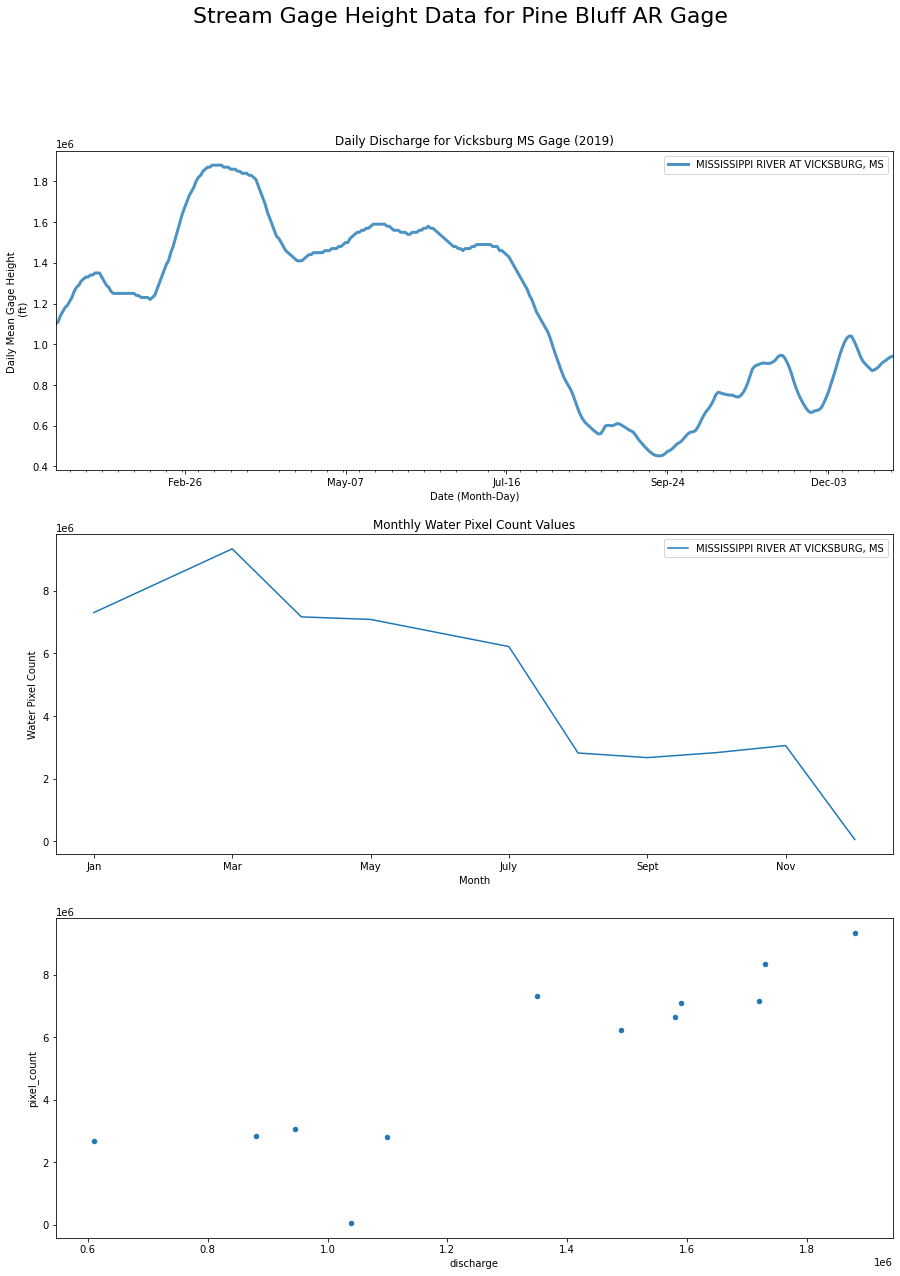

In [16]:

# Define plot space, overall size and title
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 20))

fig.suptitle(
    "Stream Gage Height Data for Pine Bluff AR Gage", fontsize=22)

# Loop for plotting Subplot 1
vicksburg_site_df.plot(y='discharge',
                       title="Daily Discharge for Vicksburg MS Gage (2019)",
                       label='MISSISSIPPI RIVER AT VICKSBURG, MS',
                       linewidth=3.0,
                       ax=ax1,
                       alpha=.8)
df.plot(y='nd', 
       ax=ax2, title = "Monthly Water Pixel Count Values", label = "MISSISSIPPI RIVER AT VICKSBURG, MS")

vicksburg_max_month_gage.plot(kind = 'scatter',
                                x='discharge',
                                y ='pixel_count',
                                ax=ax3)

# Define the date format for Subplot 1, set axis labels
date_form = DateFormatter("%b-%d")
ax1.xaxis.set_major_formatter(date_form)
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
ax1.set(xlabel="Date (Month-Day)",
        ylabel="Daily Mean Gage Height \n (ft)")
ax2.set(xlabel="Month",
       ylabel="Water Pixel Count")

#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 11})

In [ ]:
# Need to figure out how to iterate through months. (datetime package?)